In [1]:
using Pkg
Pkg.activate("..")
using SVDD
using OneClassActiveLearning
using OneClassSampling
using MLKernels
using Random
using JuMP, Gurobi
using Printf
using Plots
pyplot()

Activating environment at `/var/ssd/p/ocs-evaluation/Project.toml`


Plots.PyPlotBackend()

In [2]:
using Memento
Memento.config!(OneClassSampling.LOGGER, "warn"; fmt="[{level} | {name}]: {msg}")
Memento.config!(SVDD.LOGGER, "warn"; fmt="[{level} | {name}]: {msg}")

Logger(SVDD)

In [3]:
include("../scripts/util/evaluate.jl")

function plot_sample(sample_mask, c=:blue, t="Sample")
    model = train_svdd_model(VanillaSVDD, init_strat, solver, x[:, l .== :inlier][:, sample_mask], l[l .== :inlier][sample_mask])
    grid_pred = SVDD.predict(model, grid)
    f = scatter(x[1, l .== :inlier], x[2, l .== :inlier], label="data", ms=5, color=:grey, markerstrokecolor=:grey)
    scatter!(x[1, l .== :outlier], x[2, l .== :outlier], label="data", ms=5, color=:black, markerstrokecolor=:black)
    contour!(x_plot_axis, x_plot_axis, reshape(grid_pred_full , length(x_plot_axis), length(x_plot_axis)), levels=[0], linewidth=2, color=:grey, cbar=false, legend=true)
    scatter!(x[:, l .== :inlier,][1, sample_mask], x[:, l .== :inlier,][2, sample_mask], label=t, color=c, marker=:diamond, ms=7)
    contour!(x_plot_axis, x_plot_axis, reshape(grid_pred , length(x_plot_axis), length(x_plot_axis)), levels=[0], linewidth=2, color=c, cbar=false, style=:dash)
    return plot(f, xaxis=false, yaxis=false, grid=false, legend=false)
end

plot_sample (generic function with 3 methods)

In [4]:
Random.seed!(2)
n, n_in, n_out = 456, 450, 6
x = hcat(randn(2, Int(n_in / 2)) * 1.5 .+ 2.5, randn(2, Int(n_in / 2)) * 1 .- 2.5)
x = hcat(x, [5.49636  -4.7485   4.77141  -5.793371   -4.91661   6.13132
             6.76698  -7.03297  8.35749   2.58823     6.14924  -2.51147])
l = vcat(fill(:inlier, n_in), fill(:outlier, n_out))

x_plot = hcat([[x, y] for x in range(-10, stop=10, length=100) for y in range(-10, stop=10, length=100)]...)
x_plot_axis = collect(range(-10, stop=10, length=100))

gurobi_env = Gurobi.Env()
solver = with_optimizer(Gurobi.Optimizer, gurobi_env; OutputFlag=0, Threads=1)
init_strat = SVDD.SimpleCombinedStrategy(SVDD.FixedGammaStrategy(MLKernels.GaussianKernel(0.06)), SVDD.FixedCStrategy(1))
threshold_strat = GroundTruthThresholdStrategy();

Academic license - for non-commercial use only


Train SVDD on full data set. Update labels to learnable once.

In [5]:
grid = hcat([[x,y] for x in x_plot_axis for y in x_plot_axis]...)
model_full = train_svdd_model(VanillaSVDD, init_strat, solver, x[:, l .== :inlier], l[l .== :inlier])
grid_pred_full = SVDD.predict(model_full, grid);

Run sampling methods. Competitor in blue and our method in red.

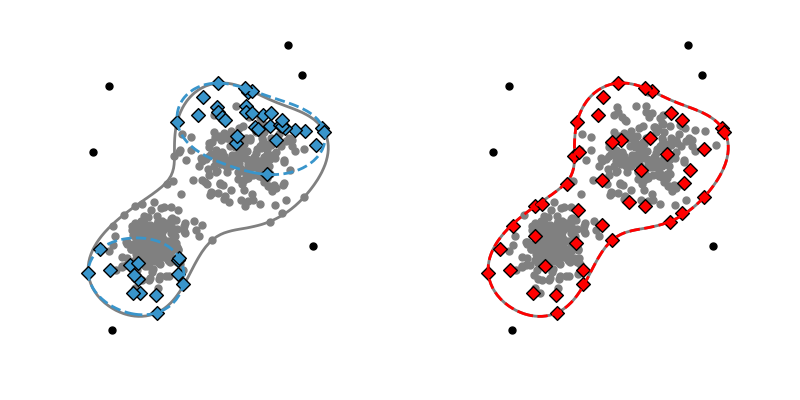

In [6]:
competitor = FBPE(360)
competitor_sample_mask = sample(competitor, x[:, l .== :inlier], l[l .== :inlier])
our_method = RAPID(threshold_strat, 0.5)
our_sample_mask = sample(our_method, x[:, l .== :inlier], l[l .== :inlier])

f_competitor = plot_sample(competitor_sample_mask, RGB(57/256, 150 / 256, 204 / 256))
f_our_method = plot_sample(our_sample_mask, :red)
f = plot(f_competitor, f_our_method, layout=(1, 2), size=(800, 400))

In [7]:
savefig(f, "../plots/intro_example.pdf")
savefig(f, "../plots/intro_example.png")